## Reflectance Index for Water Way [0.095 LB] ##

In [2]:
# libs
from __future__ import division
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from collections import defaultdict
import pandas as pd
import cv2
import os
import shapely
from shapely.geometry import MultiPolygon, Polygon

In [133]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0 
        b = 1 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.float32)

def CCCI_index(m, rgb):
    
    RE  = resize(m[5,:,:], (rgb.shape[0], rgb.shape[1])) 
    MIR = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1])) 
    R = rgb[:,:,0]

    # canopy chloropyll content index
    CCCI = (MIR-RE)/(MIR+RE)*(MIR-R)/(MIR+R)
    return CCCI    

In [134]:
data = pd.read_csv('data/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = 'data/grid_sizes.csv'
wkt_fname = 'data/train_wkt_v4.csv'
image_fname = 'data/three_band/'

## Train images ##

In [135]:
 
holder = np.zeros((960,960,3))
holder.shape

(960L, 960L, 3L)

6020_1_4
709757
(837L, 849L)


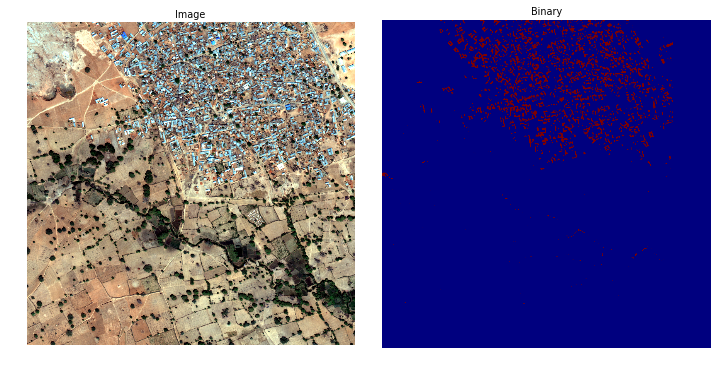

In [156]:
import cv2

for IM_ID in ["6020_1_4"]:#data[data.ClassType == 7].ImageId:
    print IM_ID
    # read rgb and m bands
    rgb = tiff.imread('data/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    
    m = tiff.imread('data/sixteen_band/{}_M.tif'.format(IM_ID))
    m = np.rollaxis(m, 0, 3)

    rgb = cv2.resize(rgb,(m.shape[1], m.shape[0]), interpolation = cv2.INTER_CUBIC)
    
    # get our index
    CCCI = CCCI_index(np.rollaxis(m, 2, 0), rgb) 
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    water = np.zeros((960,960)).astype(np.uint8)
    water[0:binary.shape[0],0:binary.shape[1]] = binary
#     print water.shape
    print np.count_nonzero(CCCI)
    print CCCI.shape
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(water)
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


In [47]:
np.unique(water)

array([0, 1], dtype=uint8)

In [67]:
ISZ = 160
for i in range(0, 6):
    line = []
    for j in range(0, 6):
        print (i,j), ":",np.sum(water[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])



(0, 0) : 3583
(0, 1) : 132
(0, 2) : 45
(0, 3) : 274
(0, 4) : 4292
(0, 5) : 918
(1, 0) : 8089
(1, 1) : 6127
(1, 2) : 110
(1, 3) : 14
(1, 4) : 743
(1, 5) : 410
(2, 0) : 59
(2, 1) : 4080
(2, 2) : 3473
(2, 3) : 675
(2, 4) : 4103
(2, 5) : 544
(3, 0) : 491
(3, 1) : 1966
(3, 2) : 9789
(3, 3) : 248
(3, 4) : 900
(3, 5) : 1122
(4, 0) : 369
(4, 1) : 844
(4, 2) : 7561
(4, 3) : 6103
(4, 4) : 56
(4, 5) : 116
(5, 0) : 51
(5, 1) : 244
(5, 2) : 18
(5, 3) : 3162
(5, 4) : 38
(5, 5) : 1


## Test images ##

11369602
0.0145727937722
(3348L, 3396L)
631444.0


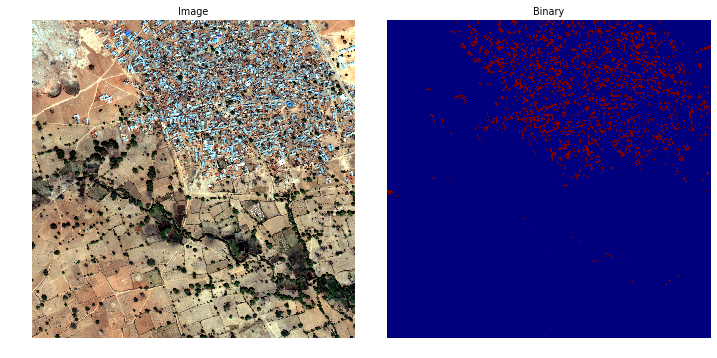

In [153]:
# take some pictures from test 
# waterway_test = ['6080_4_3','6080_4_0',
#                  '6080_1_3', '6080_1_1',
#                  '6150_3_4', '6050_2_1']
waterway_test = ["6020_1_4"]#"6010_0_4"]
for IM_ID in waterway_test:
    # read rgb and m bands
    rgb = tiff.imread('data/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('data/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = CCCI_index(m, rgb) 
    print np.count_nonzero(CCCI)
    print np.mean(CCCI)
    print CCCI.shape    
    #you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    print np.sum(binary)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary)
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [151]:
a = np.random.rand(2,3)
a = a.astype(np.bool)
a 

array([[ True,  True,  True],
       [ True,  True,  True]], dtype=bool)

## How to get 0.095 for WaterWay ##

- Use this idea with CCCI index
- Convert binary mask to polygons (take functions from some top kernels)
- Use threshold for number of pixels per image for filtering (> 500k pixels should work)
- Get your 0.095

In [ ]:
def check_predict(id='6010_0_0'):
    model = get_unet()
    model.load_weights('weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict water pixels')
    ax2.imshow(msk[6], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict water polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[6], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

(<matplotlib.figure.Figure at 0x1f684240>,
 <matplotlib.image.AxesImage at 0xb7c2518>)

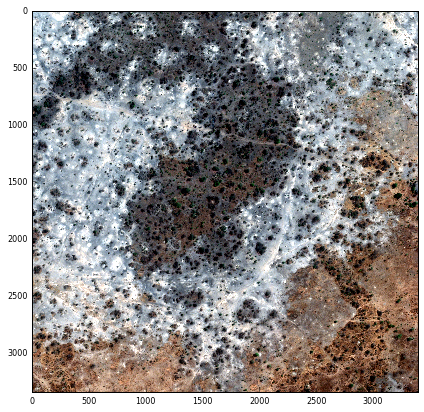

In [61]:


def rgb(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    img = tiff.imread('data/three_band/{}.tif'.format(image_id))
    img = np.rollaxis(img, 0, 3)

    return img

tiff.imshow(stretch_8bit(rgb("6010_0_4")))